# Part I. Prepare data

### 1. Create first Tensor: user_id $\times$ movie_id $\times$ rating

In [1]:
import numpy as np
import pandas as pd
import os
import torch
from tqdm import tqdm_notebook

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1GNllmHs0cH8FQVu68AwrttMzere4KJhG',
                                    dest_path='./ratings.dat',
                                    unzip=True)

gdd.download_file_from_google_drive(file_id='1V91TkGCwGFfeL08jpTbzsXBMndD_zWy0',
                                    dest_path='./movies.dat',
                                    unzip=True)

In [2]:
rating_data = pd.io.parsers.read_csv('ratings.dat', 
    names=['user_id', 'movie_id', 'rating', 'time'],
    engine='python', delimiter='::')

movies_data = pd.io.parsers.read_csv('movies.dat', 
    names=['movie_id', 'name', 'genre'],
    engine='python', delimiter='::')

In [3]:
import datetime

rating_data['date'] = pd.to_datetime(rating_data['time'], unit='s', origin='unix')
rating_data['year'] = rating_data['date'].apply(lambda x: x.year)
rating_data['month'] = rating_data['date'].apply(lambda x: x.month)

In [4]:
def data_truncate(key):
    user_item_key = rating_data[['user_id', key, 'movie_id']]
    user_item_key['binary'] = np.ones(user_item_key.shape[0], dtype=np.int8)
    user_item_key = user_item_key.sort_values(by=['user_id', 'movie_id'])

    return user_item_key

In [5]:
def fill_extra_movies(data_user, column): 
    extra_movies = []
    users = data_user.user_id.unique()

    for user in tqdm_notebook(users):
        current_user_frame = data_user[data_user['user_id'] == user]
        movies_user = current_user_frame['movie_id'].unique()

        add_movies = np.array(list(set(all_movies) - set(movies_user)))
        qty_movies = add_movies.shape[0]

        user_rate = np.tile([user, 1], qty_movies).reshape(qty_movies, 2)
        binary_col = np.zeros(qty_movies, dtype=np.int8)[:, None]

        res_frame = np.hstack((user_rate, add_movies[:, None], binary_col))
        extra_movies.append(res_frame)

    extra_frame = pd.DataFrame(np.vstack(extra_movies), columns=['user_id', column, 'movie_id', 'binary'])
    data_new = pd.concat((data_user, extra_frame))

    return data_new

In [6]:
def create_pivot(data_user, column):
    pivot = pd.pivot_table(data_user, values='binary', index=['user_id', 'movie_id'],
                        columns=[column])
    
    pivot = pivot.fillna(0)
    return pivot

In [ ]:
user_item_rate = data_truncate('rating')
all_movies = np.sort(user_item_rate.movie_id.unique()) #Calculate only once

In [ ]:
data_uir = fill_extra_movies(user_item_rate, 'rating')

In [9]:
uir_pivot = create_pivot(data_uir, 'rating')

In [10]:
num_of_users = rating_data.user_id.nunique() #Calculate only once
num_of_movies = rating_data.movie_id.nunique() #Calculate only once
num_of_rates = rating_data.rating.nunique()

In [11]:
user_movie_rate_array = uir_pivot.values.reshape(num_of_users, num_of_movies, num_of_rates)
sparse_user_movie_rate = torch.tensor(user_movie_rate_array)

In [12]:
users = sparse_user_movie_rate.shape[0]

In [12]:
feedback_tensor_train = sparse_user_movie_rate[:int(users * 0.7)]
feedback_tensor_test = sparse_user_movie_rate[int(users * 0.7):]

### 2. Create second Tensor: user_id  ×  movie_id  ×  month

In [ ]:
user_item_month = data_truncate('month')
all_movies = np.sort(user_item_month.movie_id.unique()) #Calculate only once

In [8]:
data_uim = fill_extra_movies(user_item_month, 'month')
uim_pivot = create_pivot(data_uim, 'month')
num_of_users = rating_data.user_id.nunique() #Calculate only once
num_of_movies = rating_data.movie_id.nunique() #Calculate only once
num_of_months = rating_data.month.nunique()

user_movie_month_array = uim_pivot.values.reshape(num_of_users, num_of_movies, num_of_months)
sparse_user_movie_month = torch.tensor(user_movie_month_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [10]:
users = sparse_user_movie_month.shape[0]
context_tensor_train = sparse_user_movie_month[:int(users * 0.7)]
context_tensor_test = sparse_user_movie_month[int(users * 0.7):]

# Part II. Apply Tenosrly Tucker decomposition and recommend

### 1. Feedback tensor recommends

In [16]:
#!pip install tensorly

In [17]:
feedback_tensor_train = np.array(feedback_tensor_train)

In [18]:
from tensorly.decomposition import tucker

core, (U, V, W) = tucker(feedback_tensor_train, rank=[20, 20, 5])

In [19]:
# {0: 1, 1: 3, 2: 4} - индексирование фильмов
movie_mapping = {x: y for x, y in enumerate(sorted(data_uir.movie_id.unique()))}

# {0: 1, 1: 3, 2: 4} - индексирование юзеров (необязательно)
user_mapping = {x: y for x, y in enumerate(sorted(data_uir.user_id.unique()))}

# {0: 1, 1: 3, 2: 4} - индексирование юзеров в трейне
user_mapping_train = {key: item for key, item in user_mapping.items() if key < int(users * 0.7)}

# {0: 2000, 1: 2001, 2: 2002} - индексирование юзеров в тесте
user_mapping_test = {key: item for key, item in user_mapping.items() if key >= int(users * 0.7)}
user_mapping_test = {index: value for index, value in enumerate(user_mapping_test.values())}

In [20]:
def calculate_predictions(test_tensor, i, V, W, user_mapping_test):
    unknown_user = np.array(test_tensor[i])
    user_test_id = user_mapping_test[i]

    nonzero_row, nonzero_col  = np.nonzero(unknown_user)

    movie_to_rating = {}

    for _ in range(int(len(nonzero_row) * 0.3)): # Зануление оценок фильмов для дальнейшего предикта
        array_nonzero = np.nonzero(unknown_user)
        nonzero_row, nonzero_col = np.nonzero(unknown_user)
        nonzero_indeces = list(zip(nonzero_row, nonzero_col))
        np.random.shuffle(nonzero_indeces)

        index, value = nonzero_indeces[0]
        
        deleted_movie_id = movie_mapping[index]
        movie_to_rating[deleted_movie_id] = value

        unknown_user[index, value] = 0

    R_unknown_user = V @ V.T @ unknown_user @ W @ W.T
    R_unknown_user += abs(R_unknown_user.min())

    rate_index_max = np.argmax(R_unknown_user, axis=1) 
    rate_index_prob = R_unknown_user[np.arange(R_unknown_user.shape[0]), rate_index_max]

    data_rate = pd.DataFrame(np.hstack((rate_index_max[:, None], rate_index_prob[:, None])), columns=['max_rate_index', 'prob'])
    data_rate['max_rate_index'] = data_rate['max_rate_index'].astype(int)
    data_rate = data_rate.sort_values(by=['max_rate_index', 'prob'], ascending=False)

    movie_to_rating_predict = data_rate[data_rate.index.isin(movie_to_rating.keys())]['max_rate_index'].to_dict()

    result_df_true = pd.DataFrame.from_dict(movie_to_rating, orient="index", columns=["true"])
    result_df_predict = pd.DataFrame.from_dict(movie_to_rating_predict, orient="index", columns=["predict"])

    result_df = pd.merge(result_df_predict, result_df_true, left_index=True, right_index=True)

    return result_df


In [ ]:
df_list = []
for i in tqdm_notebook(range(feedback_tensor_test.shape[0])):
    df_list.append(calculate_predictions(feedback_tensor_test, i, V, W, user_mapping_test))

big_df = pd.concat(df_list)

Metric 1: Feedback value deviation 

In [22]:
feedback_value_deviation = abs(big_df.predict - big_df.true)

Metric 2: Feedback metric table

In [23]:
from sklearn.metrics import ndcg_score, precision_score, recall_score, accuracy_score, f1_score

metrics = []
for threshold in range(0, 5):
    predict = big_df.predict.apply(lambda x: 1 if x >= threshold else 0)
    true = big_df.true.apply(lambda x: 1 if x >= threshold else 0)
    precision = precision_score(true, predict)
    ndcg = ndcg_score(np.asarray([true]), np.asarray([predict]))
    recall = recall_score(true, predict)
    accuracy = accuracy_score(true, predict)
    f1 = f1_score(true, predict)

    result = {"precision": precision, "ndcg": ndcg, "recall": recall, "accuracy": accuracy, "f1": f1}

    metrics.append(result)

In [24]:
feedback_metric_table = pd.DataFrame(metrics)

In [30]:
# np.save("feedback_value_deviation.npy", feedback_value_deviation)
# feedback_metric_table.to_csv("feedback_metric_table.csv")
# big_df.to_csv("rating_predict.csv")

### 2. Context tensor predictions

In [11]:
context_tensor_train = np.array(context_tensor_train)

In [12]:
from tensorly.decomposition import tucker

core, (U, V, W) = tucker(context_tensor_train, rank=[20, 20, 12])

In [13]:
# {0: 1, 1: 3, 2: 4} - индексирование фильмов
movie_mapping = {x: y for x, y in enumerate(sorted(data_uim.movie_id.unique()))}

# {0: 1, 1: 3, 2: 4} - индексирование юзеров (необязательно)
user_mapping = {x: y for x, y in enumerate(sorted(data_uim.user_id.unique()))}

# {0: 1, 1: 3, 2: 4} - индексирование юзеров в трейне
user_mapping_train = {key: item for key, item in user_mapping.items() if key < int(users * 0.7)}

# {0: 2000, 1: 2001, 2: 2002} - индексирование юзеров в тесте
user_mapping_test = {key: item for key, item in user_mapping.items() if key >= int(users * 0.7)}
user_mapping_test = {index: value for index, value in enumerate(user_mapping_test.values())}

In [14]:
def calculate_predictions_month(test_tensor, i, V, W, user_mapping_test):
    unknown_user = np.array(test_tensor[i])
    user_test_id = user_mapping_test[i]

    nonzero_row, nonzero_col  = np.nonzero(unknown_user)

    movie_to_month = {}

    for _ in range(int(len(nonzero_row) * 0.3)): # Зануление оценок фильмов для дальнейшего предикта
        array_nonzero = np.nonzero(unknown_user)
        nonzero_row, nonzero_col = np.nonzero(unknown_user)
        nonzero_indeces = list(zip(nonzero_row, nonzero_col))
        np.random.shuffle(nonzero_indeces)

        index, value = nonzero_indeces[0]
        
        deleted_movie_id = movie_mapping[index]
        movie_to_month[deleted_movie_id] = value

        unknown_user[index, value] = 0

    R_unknown_user = V @ V.T @ unknown_user @ W @ W.T
    R_unknown_user += abs(R_unknown_user.min())

    month_index_max = np.argmax(R_unknown_user, axis=1) 
    month_index_prob = R_unknown_user[np.arange(R_unknown_user.shape[0]), month_index_max]

    data_month = pd.DataFrame(np.hstack((month_index_max[:, None], month_index_prob[:, None])), columns=['max_month_index', 'prob'])
    data_month['max_month_index'] = data_month['max_month_index'].astype(int)
    data_month = data_month.sort_values(by=['max_month_index', 'prob'], ascending=False)

    movie_to_month_predict = data_month[data_month.index.isin(movie_to_month.keys())]['max_month_index'].to_dict()

    result_df_true = pd.DataFrame.from_dict(movie_to_month, orient="index", columns=["true"])
    result_df_predict = pd.DataFrame.from_dict(movie_to_month_predict, orient="index", columns=["predict"])

    result_df = pd.merge(result_df_predict, result_df_true, left_index=True, right_index=True)

    return result_df


In [15]:
df_list_month = []

In [ ]:
for i in tqdm_notebook(range(context_tensor_test.shape[0])):
    df_list_month.append(calculate_predictions_month(context_tensor_test, i, V, W, user_mapping_test))

In [17]:
big_df_month = pd.concat(df_list_month)

In [19]:
# month_value_deviation = abs(big_df_month.predict - big_df_month.true)
# np.save("month_value_deviation.npy", month_value_deviation)

In [20]:
def get_window(window, true, predict):
    min_val, max_val = true - window, true + window
    months_array = [x % 12 if (x < 0) or (x >= 12) else x for x in range(min_val, max_val + 1)]
    return int(predict in months_array)

In [21]:
def apply_window(predictions_df, win):
    binary_arr = []
    for index, row in tqdm_notebook(big_df_month.iterrows()):
        predict_val = row.predict
        true_val = row.true

        binary_val = get_window(win, true_val, predict_val)
        binary_arr.append(binary_val)

    big_df_month[f'binary_{win}'] = binary_arr

    return big_df_month

In [ ]:
for win in range(0, 6):
      big_df_month = apply_window(big_df_month, win)

In [23]:
# big_df_month.to_csv("month_predict.csv")

In [24]:
metrics = []

In [25]:
for win in range(0, 6):
    predict = big_df_month[f"binary_{win}"]
    accuracy = predict.sum()/len(predict)

    result = {"accuracy": accuracy}

    metrics.append(result)

In [26]:
tucker_context_metrics = pd.DataFrame(metrics)

In [27]:
# tucker_context_metrics.to_csv("tucker_context_metrics.csv")

# Part III. Visualistation of metrics

### 1. Feedback tensor metrics

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


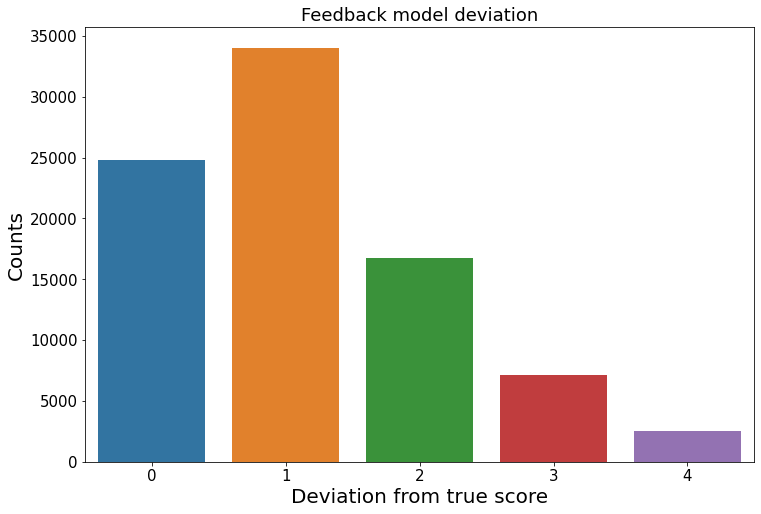

In [40]:
plt.figure(figsize=(12, 8))

sns.countplot(feedback_value_deviation)

plt.xlabel(r'Deviation from true score', fontsize=20)
plt.ylabel('Counts', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


plt.title(r'Feedback model deviation', fontsize=18);

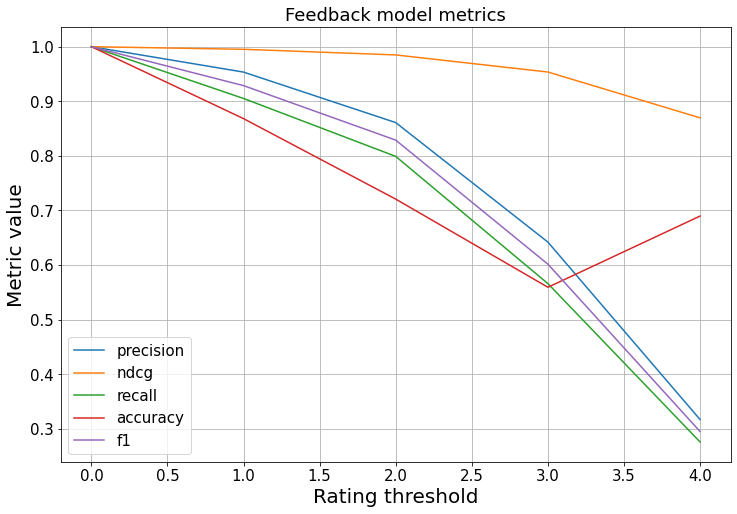

In [49]:
feedback_metric_table.plot(figsize=(12,8));

plt.xlabel(r'Rating threshold', fontsize=20)
plt.ylabel('Metric value', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

plt.grid()

plt.title(r'Feedback model metrics', fontsize=18);

### 2. Context tensor metrics

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


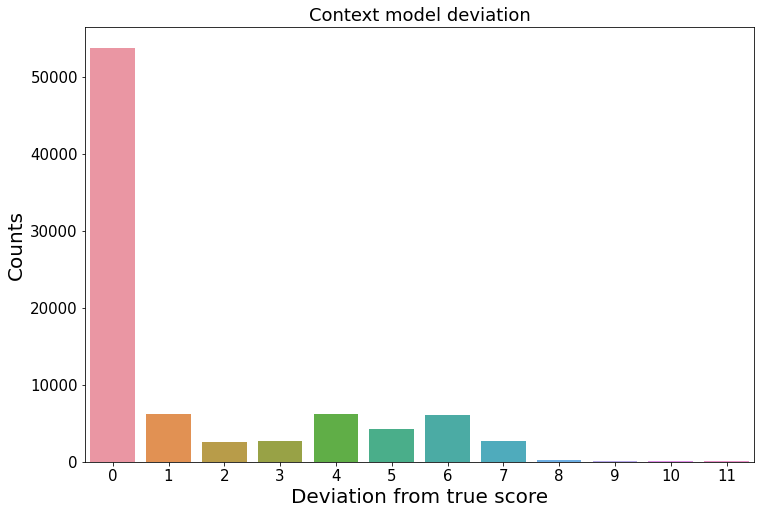

In [31]:
plt.figure(figsize=(12, 8))

sns.countplot(month_value_deviation)

plt.xlabel(r'Deviation from true score', fontsize=20)
plt.ylabel('Counts', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


feedback_metric_table.plot(figsize=(12,8));

plt.xlabel(r'Rating threshold', fontsize=20)
plt.ylabel('Metric value', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

plt.grid()

plt.title(r'Feedback model metrics', fontsize=18);plt.title(r'Context model deviation', fontsize=18);

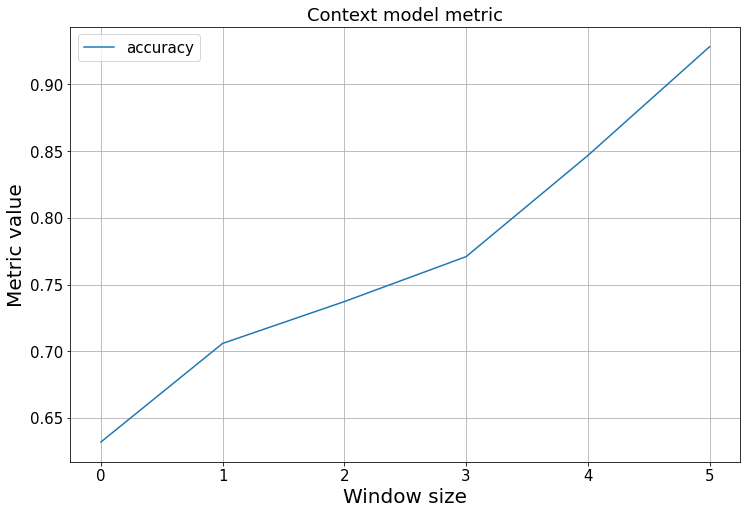

In [36]:
tucker_context_metrics.plot(figsize=(12,8));

plt.xlabel(r'Window size', fontsize=20)
plt.ylabel('Metric value', fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

plt.grid()

plt.title(r'Context model metric', fontsize=18);

# Part IV. Demo

In [95]:
feedback_df = pd.read_csv("rating_predict.csv")

In [96]:
user_id = []
previous_indeces = []
current_user_id = 0
for index, row in feedback_df.iterrows():
      if row['Unnamed: 0'] in previous_indeces:
            previous_indeces = []
            current_user_id += 1
      previous_indeces.append(row['Unnamed: 0'])
      user_id.append(current_user_id)

In [97]:
feedback_df['user_id'] = user_id
feedback_df.user_id = feedback_df.user_id.apply(lambda x: user_mapping_test[x])
test_user_id = feedback_df.user_id.unique()[2]
fav_movie_ids = list(rating_data[(rating_data.user_id == test_user_id) & (rating_data.rating == 5)].movie_id)
pred_movie_ids = list(feedback_df[(feedback_df.user_id == test_user_id) & (feedback_df.predict == 4)]["Unnamed: 0"])

##### Test user's favorite movies:

In [98]:
movies_data[movies_data.movie_id.isin(fav_movie_ids)][["name"]]

,name
0,Toy Story (1995)
33,Babe (1995)
436,Dave (1993)
476,Jurassic Park (1993)
496,Mrs. Doubtfire (1993)
583,Ghost (1990)
1000,"Parent Trap, The (1961)"
1179,"Princess Bride, The (1987)"
1271,Indiana Jones and the Last Crusade (1989)
2016,101 Dalmatians (1961)


##### We recommend:

In [99]:
movies_data[movies_data.movie_id.isin(pred_movie_ids)][["name"]]

,name
1,Jumanji (1995)
642,Mission: Impossible (1996)
1219,Local Hero (1983)
1236,Duck Soup (1933)
1263,High Noon (1952)
1899,"Breakfast Club, The (1985)"
2011,Lady and the Tramp (1955)
2031,Splash (1984)
2124,Willow (1988)
2719,And Now for Something Completely Different (1971)
